Before you turn in the homework, make sure everything runs as expected. To do so, select **Kernel**$\rightarrow$**Restart & Run All** in the toolbar above.  Remember to submit both on **DataHub** and **Gradescope**.

Please fill in your name and include a list of your collaborators below.

In [1]:
NAME = "Sanjiv Murthy"
COLLABORATORS = ""

---

# Project 2: NYC Taxi Rides
# Part 2: EDA, Visualization, Feature Engineering

In this part, we will conduct EDA on the NYC Taxi dataset that we cleaned and train/validation split in part 1. We will also guide you through the engineering of some features that hopefully will help our model to accurately understand the data.


# Imports

Let us start by loading the Python libraries and custom tools we will use in this part.  

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

sns.set(style="whitegrid", palette="muted")
%matplotlib inline

## Loading & Formatting data

The following code loads the data into a pandas DataFrame.

In [3]:
# Run this cell to load the data. 
data_file = Path("data/part1", "cleaned_data.hdf")
train_df = pd.read_hdf(data_file, "train")

In [4]:
train_df.head()

,record_id,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
16434,8614300,2,2016-01-21 17:37:12,2016-01-21 18:37:56,2,10.89,-73.863403,40.769432,1,N,...,40.688210,1,41.5,1.0,0.5,6.00,0.0,0.3,49.30,3644.0
21929,7230200,2,2016-01-29 23:22:26,2016-01-29 23:31:23,2,1.00,-74.008087,40.739365,1,N,...,40.729271,1,7.0,0.5,0.5,1.66,0.0,0.3,9.96,537.0
3370,9830300,2,2016-01-05 18:50:16,2016-01-05 18:56:00,2,0.56,-73.972923,40.755650,1,N,...,40.758469,1,5.0,1.0,0.5,1.00,0.0,0.3,7.80,344.0
21975,7251500,2,2016-01-30 00:14:34,2016-01-30 00:47:13,1,6.65,-73.992027,40.718662,1,N,...,40.661118,1,25.5,0.5,0.5,2.68,0.0,0.3,29.48,1959.0
13758,6168000,1,2016-01-18 13:25:24,2016-01-18 13:38:51,1,2.10,-73.953125,40.784538,1,N,...,40.760792,2,11.5,0.0,0.5,0.00,0.0,0.3,12.30,807.0


## 1: Data Overview 

As a reminder, the raw taxi data contains the following columns:
- `recordID`: primary key of this database
- `VendorID`: a code indicating the provider associated with the trip record
- `passenger_count`: the number of passengers in the vehicle (driver entered value)
- `trip_distance`: trip distance
- `tpep_dropoff_datetime`: date and time when the meter was engaged
- `tpep_pickup_datetime`: date and time when the meter was disengaged
- `pickup_longitude`: the longitude where the meter was engaged
- `pickup_latitude`: the latitude where the meter was engaged
- `dropoff_longitude`: the longitude where the meter was disengaged
- `dropoff_latitude`: the latitude where the meter was disengaged
- `duration`: duration of the trip in seconds
- `payment_type`: the payment type
- `fare_amount`: the time-and-distance fare calculated by the meter
- `extra`: miscellaneous extras and surcharges
- `mta_tax`: MTA tax that is automatically triggered based on the metered rate in use	
- `tip_amount`: the	amount of credit card tips, cash tips are not included
- `tolls_amount`: amount paid for tolls
- `improvement_surcharge`: fixed fee
- `total_amount`: total amount paid by passengers, cash tips are not included

Let us take a closer look at the target `duration` variable. In the cell below, we plot its distribution using `sns.distplot`. This should give us an idea about whether we have some outliers in our data.

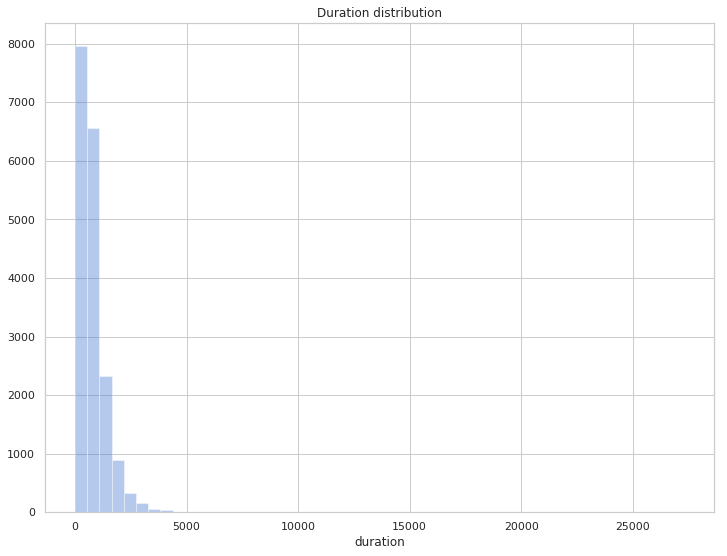

In [5]:
fig, ax = plt.subplots(figsize=(12, 9))

# Plot the distribution of duration using sns.distplot
# You can fill `ax=ax` to sns.distplot to plot in the ax object created above

sns.distplot(train_df['duration'], ax=ax, kde=False)

plt.title('Duration distribution');

As expected for a positive valued variable, we observe a skewed distribution. Note that we seem to have a handful of very long trips within our data. Use an appropriate data transformation to squeeze this highly-skewed distribution. Plot a `sns.distplot` of the transformed duration data for `train_df`.

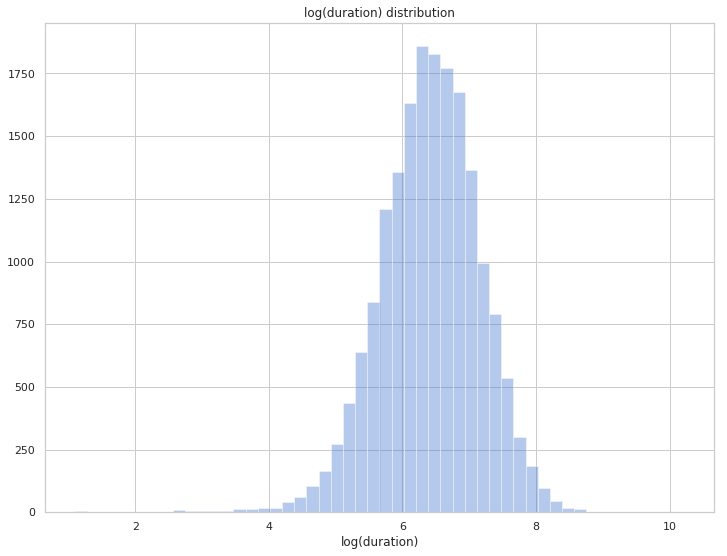

In [6]:
fig, ax = plt.subplots(figsize=(12, 9))

# Use a log transformation to squeeze the distribution
# You can add + 1 to all values before taking the log to handle possible 0 values for distribution

sns.distplot(np.log(train_df['duration'] + 1),
             ax=ax,
             axlabel='log(duration)',
             kde=False)

plt.title('log(duration) distribution');

After transforming our data, we should immediately observe that we are dealing with what seems to be log-normal distribution for the target variable `duration`. We can see the behavior of shorter rides better, whereas before they were lumped in a bar near 0. This is a nice result, since it can facilitate modeling later. 

**Note:** Keep in mind that we want to avoid peeking at our validation data because it may introduce bias. Therefore, we will be focusing on analyzing the training data for the remainder of this notebook.

## 2: Date Analysis

In order to understand the general pattern/trends of our taxi ride data, we will plot the number of taxi rides requested over time. Please run the following cell.

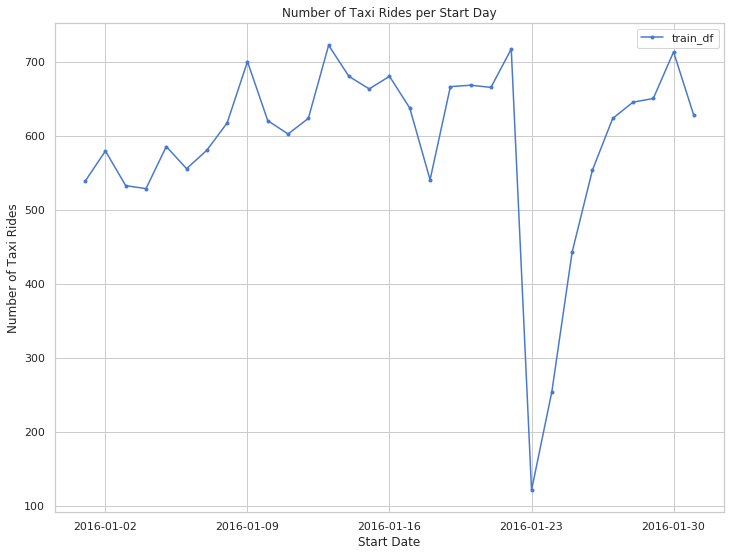

In [7]:
plt.figure(figsize=(12, 9))

# Make a temporary copy of our datasets
tmp_train = train_df.copy()
tmp_train['date'] = tmp_train['tpep_pickup_datetime'].dt.date
tmp_train = tmp_train.groupby('date').count()['pickup_longitude']

# Plot the temporal overlap
plt.plot(tmp_train, '.-', label='train_df')

plt.title('Number of Taxi Rides per Start Day')
plt.xlabel("Start Date")
plt.legend()
plt.ylabel('Number of Taxi Rides');

### Question 2a
Taking a closer look at the plot above, we notice a drastic drop in taxi rides towards the end of Janurary.
What is the date corresponding to the lowest number of taxi rides? Enter your answer as a string in the format MM-DD-YYYY.

In [8]:
lowest_rides_date = "01-23-2016"

# YOUR CODE HERE
# raise NotImplementedError()

print(lowest_rides_date)

01-23-2016


In [9]:
# Hidden test!

### Question 2b
What event could have caused this drop in taxi rides? Feel free to use Google.

In [10]:
q2b_answer = r"""

January 23 was the most severe day of the worst blizzard in NYC history. The dangerous road conditions probably stopped drivers and customers from being on the road during that day.

"""

# YOUR CODE HERE
# raise NotImplementedError()

print(q2b_answer)



January 23 was the most severe day of the worst blizzard in NYC history. The dangerous road conditions probably stopped drivers and customers from being on the road during that day.




## 3. Spatial/Locational Analysis

We are curious about the distribution of taxi pickup/dropoff coordinates. We also may be interested in observing whether this distribution changes as we condition of longer/shorter taxi rides. In the cells below, we will categorize our data into long and short rides based on duration. Then we will plot the latitude and longitude coordinates of rides conditioned on these categories.

First you may want to familiarize yourself with a [map of Manhattan](https://www.google.com/maps/place/Manhattan,+New+York,+NY/@40.7590402,-74.0394431,12z/data=!3m1!4b1!4m5!3m4!1s0x89c2588f046ee661:0xa0b3281fcecc08c!8m2!3d40.7830603!4d-73.9712488).

Here we split `train_df` into two data frames, one called `short_rides` and one called `long_rides`. `short_rides` should contain all rides less than or equal to 15 minutes and `long_rides` should contain rides more than 15 minutes. 

**Note:** We chose 15 minutes because the mean duration of a ride is roughly 700 seconds ~ 12 minutes. We then round up to the nearest nice multiple of 5. Note that you should adjust how you determine short/long rides and outliers when feature engineering.

In [11]:
short_rides = train_df[train_df["duration"] <= 900] # rides less than or equal to 15 mins
long_rides = train_df[train_df["duration"] > 900] # rides more than 15 minutes

In [12]:
assert len(short_rides) == 12830
assert len(long_rides) == 5524

Below we generate 4 scatter plots. The scatter plots are ordered as follows:

* ax1: plot the __start__ location of short duration rides
* ax2: plot the __start__ location of long duration rides
* ax3: plot the __end__ location of short duration rides
* ax4: plot the __end__ location of long duration rides

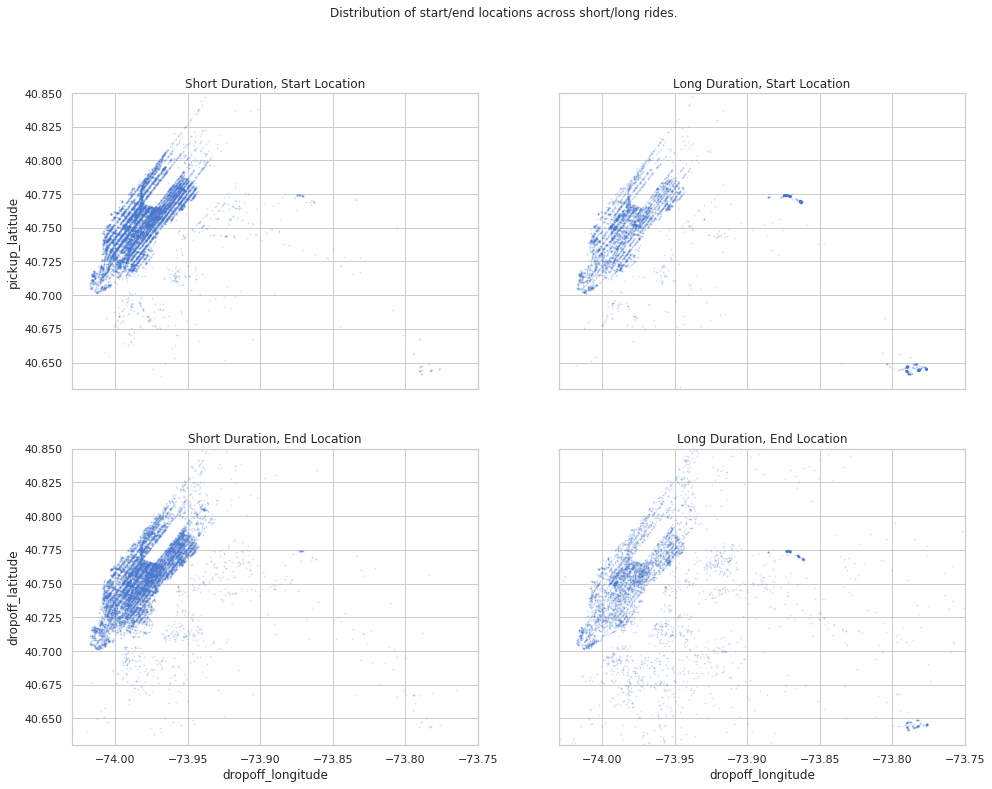

In [13]:
# Set random seed of reproducibility
random.seed(42)

# City boundaries
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# Define figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows = 2, figsize=(16, 12), sharex=True, sharey=True)
alpha = 0.15 # make sure to include these as an argument
s = 1 # make sure to include this as an argument

short_rides.plot(kind = "scatter", x = "pickup_longitude", y = "pickup_latitude",
                     ax = ax1, alpha = alpha, s = s, title='Short Duration, Start Location')
long_rides.plot(kind = "scatter", x = "pickup_longitude", y = "pickup_latitude",
                    ax = ax2, alpha = alpha, s = s, title='Long Duration, Start Location')
short_rides.plot(kind = "scatter", x = "dropoff_longitude", y = "dropoff_latitude",
                     ax = ax3, alpha = alpha, s = s , title='Short Duration, End Location')
long_rides.plot(kind = "scatter", x = "dropoff_longitude", y = "dropoff_latitude",
                    ax = ax4, alpha = alpha, s = s, title='Long Duration, End Location')


fig.suptitle('Distribution of start/end locations across short/long rides.')


plt.ylim(city_lat_border)
plt.xlim(city_long_border);

### Question 3a

What do the plots above look like? 

In particular:
- Find what the following circled regions correspond to:
<img src="figs/nyc_locations.png" width="50%"></img>

**Hint: Here is a [page](https://www.google.com/maps/place/Manhattan,+New+York,+NY/@40.7590402,-74.0394431,12z/data=!3m1!4b1!4m5!3m4!1s0x89c2588f046ee661:0xa0b3281fcecc08c!8m2!3d40.7830603!4d-73.9712488) that may be useful.**

In [14]:
q3a_answer = r"""

The inner square corresponds to the Upper East Side. The outer circle corresponds to the greater Manhattan Area. The circle off to the right corresponds to LaGuardia Airport.

"""

# YOUR CODE HERE
# raise NotImplementedError()

print(q3a_answer)



The inner square corresponds to the Upper East Side. The outer circle corresponds to the greater Manhattan Area. The circle off to the right corresponds to LaGuardia Airport.




### Question 3b
In each scatter plot above, why are there no points contained within the small rectangular region (towards the top left between the blue points)? Could this be an error/mistake in our data?

In [15]:
q3b_answer = r"""

There are no points there because geographically, that is the New Jersey area, which is not represented in our dataset.
"""

# YOUR CODE HERE
# raise NotImplementedError()

print(q3b_answer)



There are no points there because geographically, that is the New Jersey area, which is not represented in our dataset.



### Question 3c
What observations/conclusions do you make based on the scatter plots above? In particular, how are trip duration and pickup/dropoff location related?

In [16]:
q3c_answer = r"""

For short duration rides, the scatter plot of pickup and dropoff locations look nearly identical. This indicates that people are mostly making short rides within the same area. For longer rides, there is a little more variation in the pickup/dropoff location. This indicates that people who make longer trips are traveling away from Manhattan.

"""

# YOUR CODE HERE
# raise NotImplementedError()

print(q3c_answer)



For short duration rides, the scatter plot of pickup and dropoff locations look nearly identical. This indicates that people are mostly making short rides within the same area. For longer rides, there is a little more variation in the pickup/dropoff location. This indicates that people who make longer trips are traveling away from Manhattan.




This confirms that the trips are localized in NYC, with a very strong concentration in Manhattan **and** on the way to LaGuardia Airport. This might give you ideas of relevant features for feature engineering.  

Another way to visualize ride coordinates is using a **heat map** (this also helps us avoid overplotting). The following plots count the number of trips for NYC neighborhoods and areas, plotting with the `geopandas` package and theses [shapefiles](https://geo.nyu.edu/catalog/nyu_2451_36743) (do not mind the values on the colorbar). If you are curious about how to create the figures below, feel free to check out [`geopandas`](http://geopandas.org/).

![neighborhoods](figs/chloro_NY_neighborhoods.png)
![neighborhoods](figs/chloro_NY_taxi_zones.png)

## 4: Temporal features
We can utilize the `start_timestamp` column to design a lot of interesting features.

We implement the following temporal (related to time) features using the `add_time_columns` function below.
- `month` derived from `start_timestamp`.
- `week_of_year` derived from `start_timestamp`.
- `day_of_month` derived from `start_timestamp`.
- `day_of_week` derived from `start_timestamp`.
- `hour` derived from `start_timestamp`.
- `week_hour` derived from `start_timestamp`.

**Note 1**: You can use the `dt` attribute of the `start_timestamp` column to convert the entry into a `DateTime` object.

**Note 2**: We set `df.is_copy = False` to explicitly write back to the original dataframe, `df`, that is being passed into the `add_time_columns` function. Otherwise `pandas` will complain.

In [17]:
def add_time_columns(df):
    """
    Add temporal features to df
    """
    df.is_copy = False 
    df.loc[:, 'month'] = df['tpep_pickup_datetime'].dt.month
    df.loc[:, 'week_of_year'] = df['tpep_pickup_datetime'].dt.weekofyear
    df.loc[:, 'day_of_month'] = df['tpep_pickup_datetime'].dt.day
    df.loc[:, 'day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
    df.loc[:, 'hour'] = df['tpep_pickup_datetime'].dt.hour
    df.loc[:, 'week_hour'] = df['tpep_pickup_datetime'].dt.weekday * 24 + df['hour']
 
    # No real need to return here, but we harmonize with remove_outliers for later pipelinezation
    return df

In [18]:
# Note that we are applying this transformation to train_df, short_rides and long_rides
train_df = add_time_columns(train_df)
short_rides = add_time_columns(short_rides)
long_rides = add_time_columns(long_rides)

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [19]:
train_df[['month', 'week_of_year', 'day_of_month', 'day_of_week', 'hour', 'week_hour']].head()

,month,week_of_year,day_of_month,day_of_week,hour,week_hour
16434,1,3,21,3,17,89
21929,1,4,29,4,23,119
3370,1,1,5,1,18,42
21975,1,4,30,5,0,120
13758,1,3,18,0,13,13


Your `train_df.head()` should look like this, although the ordering of the data in `id` might be different:
![time_columns](figs/time_columns.png)

In [20]:
time_columns = ['month',
                'week_of_year',
                'day_of_month',
                'day_of_week',
                'hour',
                'week_hour']


# Check columns were created
assert all(column in train_df.columns for column in time_columns)

# Check type
assert train_df[time_columns].dtypes.nunique() == 1

assert train_df[time_columns].dtypes.nunique() == 1

### Visualizing Temporal Features

### Question 4a
Let us now use the features we created to plot some histograms and visualize patterns in our dataset. We will analyze the distribution of the number of taxi rides across months and days of the week. This can help us visualize and understand patterns and trends within our data.

This is a open ended question. Create 2 plots that visualize temporal information from our dataset. At least one of them must visualize the hour of each day. Aside from that you can use any column from `time_columns`. 

You can use the same column multiple times, but if the plots are redundant you will not receive full credit. This will be graded based on how informative each plot is and how "good" the visualization is (remember what good/bad visualizations look like for different kinds of data!).  

#### Visualization 1

Text(0,0.5,'Frequency')

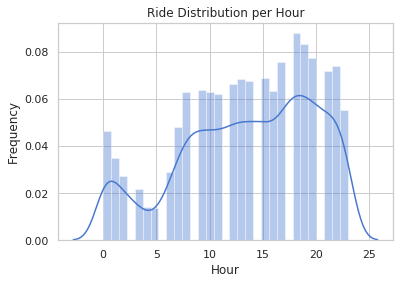

In [21]:
# Visualization 1
# YOUR CODE HERE
sns.distplot(train_df['hour'], hist = True)
plt.title("Ride Distribution per Hour")
plt.xlabel("Hour")
plt.ylabel("Frequency")

#### Visualization 2

Text(0,0.5,'Frequency')

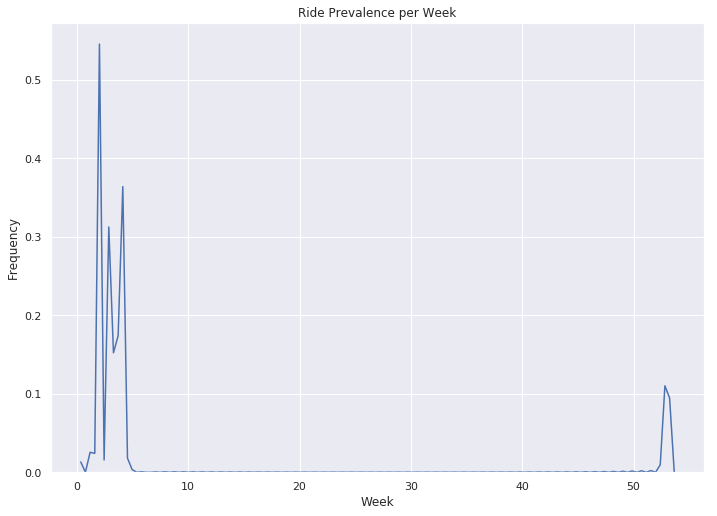

In [22]:
# Visualization 2
# YOUR CODE HERE
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(train_df['week_of_year'], hist = False)
plt.title("Ride Prevalence per Week")
plt.xlabel("Week")
plt.ylabel("Frequency")

### Question 4b
Briefly explain for each plot
1. What feature you're visualization
2. Why you chose this feature
3. Why you chose this visualization method

In [23]:
q4b_answer = r"""

Visualization 1: I'm visualizing the frequency of rides per hour. I created this visualization to understand how ridership fluctuates throughout the day. I chose the sns.distplot() method because I wanted to visualize the frequency of ridership per hour.
Visualization 2: I'm visualizing the ride prevalence per week. I created this visualization to see which weeks of the year were the busiest for taxi drivers. I was very surprised by my result, and my data was best represented by a histogram because I was looking to visualize frequency.

"""

# YOUR CODE HERE
# raise NotImplementedError()

print(q4b_answer)



Visualization 1: I'm visualizing the frequency of rides per hour. I created this visualization to understand how ridership fluctuates throughout the day. I chose the sns.distplot() method because I wanted to visualize the frequency of ridership per hour.
Visualization 2: I'm visualizing the ride prevalence per week. I created this visualization to see which weeks of the year were the busiest for taxi drivers. I was very surprised by my result, and my data was best represented by a histogram because I was looking to visualize frequency.




### Question 4c

From the various plots above, what conclusions can you draw about the temporal aspects of our data? How does this relate to duration? 

In [24]:
q4c_answer = r"""

Looking at my temporal distribution, I can tell that the highest prevalence of ridership occurs during the winter/Holiday Season. I can make the logical assumption that this is due to toursists coming to visit New York City. Since there is a large influx of tourists, they are likely to make shorter trips. 

"""

# YOUR CODE HERE
# raise NotImplementedError()

print(q4c_answer)



Looking at my temporal distribution, I can tell that the highest prevalence of ridership occurs during the winter/Holiday Season. I can make the logical assumption that this is due to toursists coming to visit New York City. Since there is a large influx of tourists, they are likely to make shorter trips. 




### Question 4d

Previously, we have analyzed the temporal features `hour` and `day_of_week` independently, but these features may in fact have a relationship between each other. Determining the extent to their relationship may be useful in helping us create new features in our model. Create a violin plot that displays distribution of rides over each hour per day of the week.

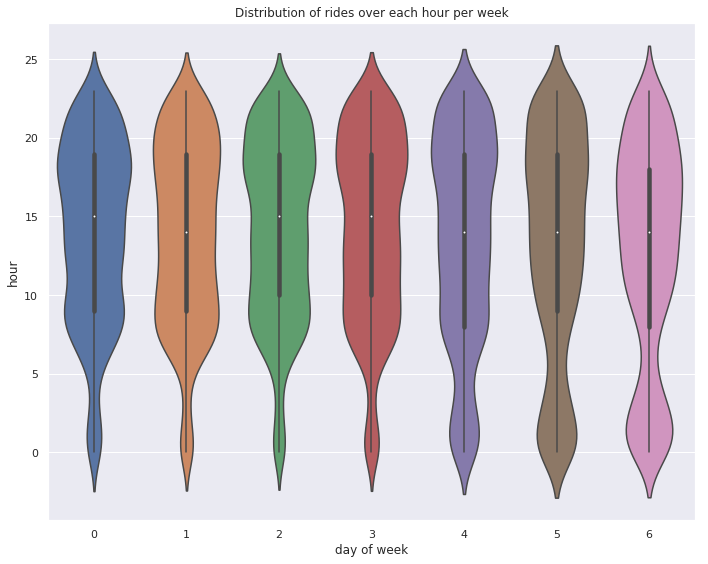

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]


# YOUR CODE HERE
sns.violinplot(x= "day_of_week", y="hour", data=train_df).set(xlabel='day of week', title ='Distribution of rides over each hour per week')
plt.tight_layout();

### Question 4e
Do you notice anything interesting about your visualization? How would you explain this plot to a lay person? What are the features/patterns of interest?

In [26]:
q4e_answer = r"""

I notice that among the days, the median and interquartile range differ but the 95% confidence interval stays the same. This indicates that the disttribution of ridership per hour differs across the days, which is a resonable assumption to make. To a lay person, I would explain that this plot visualizes the distribution of ride duration across the days of the week. 

"""

# YOUR CODE HERE
# raise NotImplementedError()

print(q4e_answer)



I notice that among the days, the median and interquartile range differ but the 95% confidence interval stays the same. This indicates that the disttribution of ridership per hour differs across the days, which is a resonable assumption to make. To a lay person, I would explain that this plot visualizes the distribution of ride duration across the days of the week. 




## 5: Vendors

Recall that in Part 1, we found that there are only two unique vendors represented in the dataset. We may wonder if the vendor feature can be useful when trying to understand taxi ride duration.

### Question 5a
Visualize the VendorID feature. Create at least one plot that gives insight as to whether this feature would be useful or not in our model.

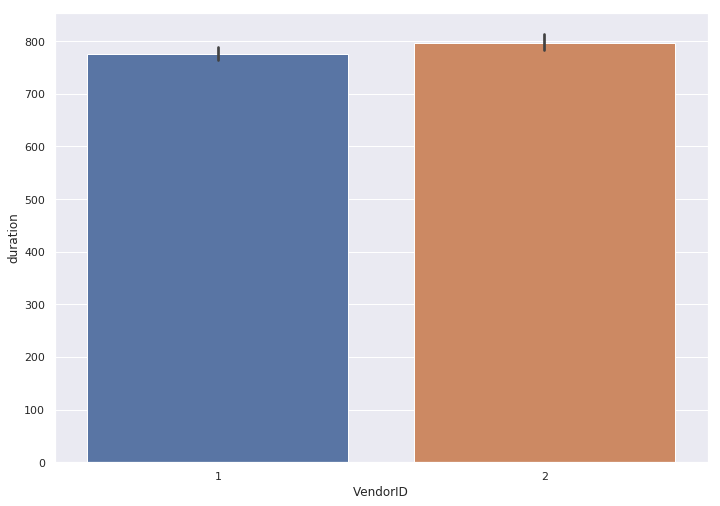

In [27]:
# Visualization

# YOUR CODE HERE
sns.barplot(x = 'VendorID', y = 'duration',data = train_df )

### Question 5b
Justify why you chose this visualization method and how it helps determine whether `vendor_id` is useful in our model or not.

In [28]:
q5b_answer = r"""

I chose a barplot because I wanted to see the duration of ridelength for each Vendor. Barplot is preferred because we are looking for the relationship between a categorical variable (vendorID) and a numeric variable (duration). By seeing whether the relationship is significantly different for each ID, we can infer if the ID is useful or not in the model.

"""

# YOUR CODE HERE
# raise NotImplementedError()

print(q5b_answer)



I chose a barplot because I wanted to see the duration of ridelength for each Vendor. Barplot is preferred because we are looking for the relationship between a categorical variable (vendorID) and a numeric variable (duration). By seeing whether the relationship is significantly different for each ID, we can infer if the ID is useful or not in the model.




### Question 5c
From the plot above, do you think vendor_id will help us understand duration? Why or why not?

In [29]:
q5c_answer = r"""

Since their durations are extremely, I can determine that vendor_id would not be a useful feature in our model. The difference is not significant enough to warrant including it in the model

"""

# YOUR CODE HERE
# raise NotImplementedError()

print(q5c_answer)



Since their durations are extremely, I can determine that vendor_id would not be a useful feature in our model. The difference is not significant enough to warrant including it in the model




## 6: Distance features

We can also use the coordinates information to compute distance features.  This will allow us to compute speed related features.  
We will compute the [haversine](https://en.wikipedia.org/wiki/Haversine_formula) distance, the [manhattan](https://en.wikipedia.org/wiki/Taxicab_geometry) distance and the [bearing](http://www.mathsteacher.com.au/year7/ch08_angles/07_bear/bearing.htm) angle.

In [30]:
# These functions are implemented for you
def haversine(lat1, lng1, lat2, lng2):
    """
    Compute haversine distance
    
    The haversine formula determines the great-circle distance between two points 
    on a sphere given their longitudes and latitudes. Important in navigation, it 
    is a special case of a more general formula in spherical trigonometry, 
    the law of haversines, that relates the sides and angles of spherical triangles.
    """
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    average_earth_radius = 6371
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * average_earth_radius * np.arcsin(np.sqrt(d))
    return h

def manhattan_distance(lat1, lng1, lat2, lng2):
    """
    Computes Manhattan distance
    
    The name alludes to the grid layout of most streets on the island of Manhattan, 
    which causes the shortest path a car could take between two intersections in the borough 
    to have length equal to the intersections' distance in taxicab geometry.
    """
    a = haversine(lat1, lng1, lat1, lng2)
    b = haversine(lat1, lng1, lat2, lng1)
    return a + b

def bearing(lat1, lng1, lat2, lng2):
    """
    Compute the bearing, or angle, from (lat1, lng1) to (lat2, lng2).
    A bearing of 0 refers to a NORTH orientation.
    """
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [31]:
def add_distance_columns(df):
    df.loc[:, 'manhattan'] = manhattan_distance(lat1=df['pickup_latitude'],
                                                lng1=df['pickup_longitude'],
                                                lat2=df['dropoff_latitude'],
                                                lng2=df['dropoff_longitude'])

    df.loc[:, 'bearing'] = bearing(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    df.loc[:, 'haversine'] = haversine(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    
    return df

In [32]:
train_df = add_distance_columns(train_df)
short_rides = add_distance_columns(short_rides)
long_rides = add_distance_columns(long_rides)

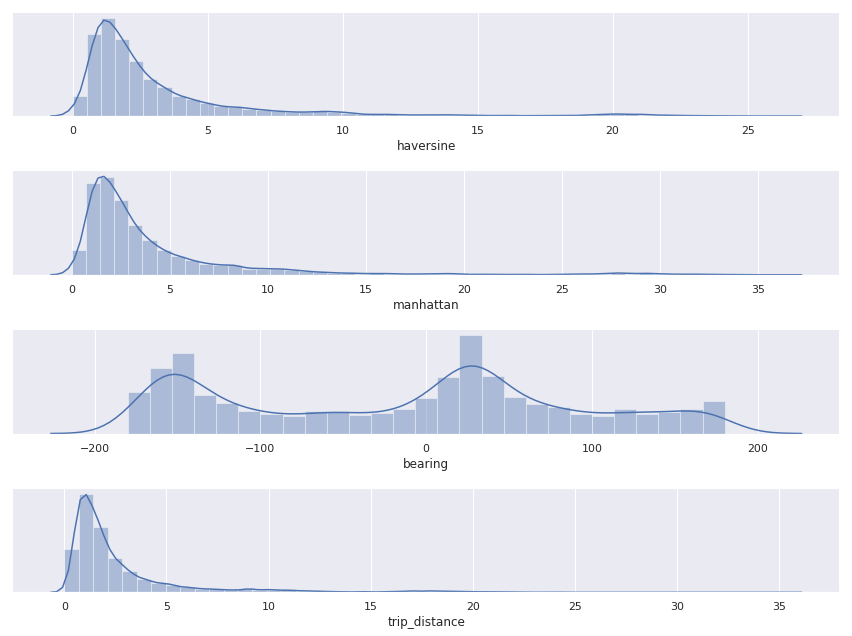

In [33]:
fig, axes = plt.subplots(4, 1, figsize=(12, 9))
sns.distplot(train_df['haversine'], ax=axes[0], axlabel='haversine');
sns.distplot(train_df['manhattan'], ax=axes[1], axlabel='manhattan');
sns.distplot(train_df['bearing'], ax=axes[2], axlabel='bearing');
sns.distplot(train_df['trip_distance'], ax=axes[3], axlabel='trip_distance');

sns.despine(left=True);
plt.setp(axes, yticks=[]);
plt.tight_layout();


### Question 6a

The `bearing` direction is angle, the initial direction of the trip.  
The bearing direction has two prominent peaks around 30 and -150 degrees.  
**Can you relate these peaks to the orientation of Manhattan? What do you notice about these angles?**

**Hint:** This [wikipedia article](https://en.wikipedia.org/wiki/Commissioners%27_Plan_of_1811) has the answer, although it may take some digging. Alternatively, try to look at a map of Manhattan.

In [34]:
q6a_answer = r"""

By coordinating these peaks to the orientation of Manhattan, we notice that 30 degree bearing angle is the direction of going uptown from lower Manhattan. -150 degree bearing angle is the direction of going towards LaGuardia Airport from lower Manhattan. 

"""

# YOUR CODE HERE
# raise NotImplementedError()

print(q6a_answer)



By coordinating these peaks to the orientation of Manhattan, we notice that 30 degree bearing angle is the direction of going uptown from lower Manhattan. -150 degree bearing angle is the direction of going towards LaGuardia Airport from lower Manhattan. 




### Question 6b

For haversine and manhattan distances, it is probably more helpful to look at the log distribution. We are also curious about whether these distance features can help us understand duration. Create at least one plot that compares haversine and manhattan distances and gives insight as to whether this would be a useful feature in our model.

[Text(0,0.5,'duration'), Text(0.5,1,'Distribution of Manhattan Distance')]

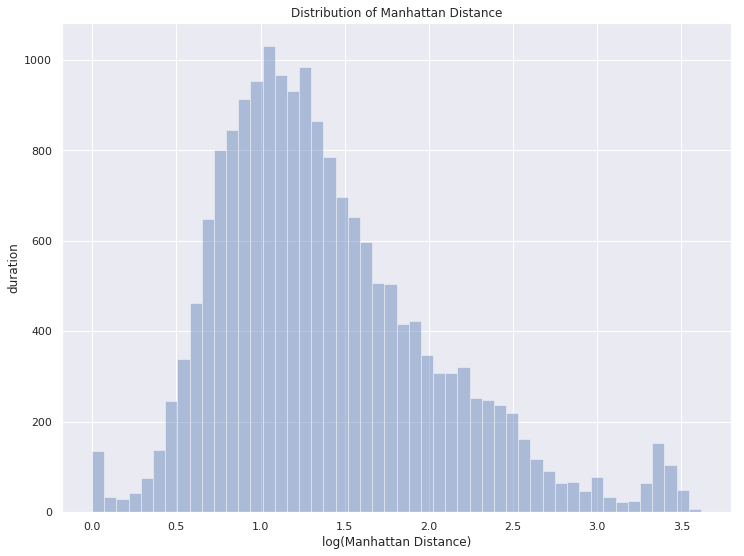

In [35]:
# Visualization
# YOUR CODE HERE
fig, ax = plt.subplots(figsize=(12, 9))

# Use a log transformation to squeeze the distribution
# You can add + 1 to all values before taking the log to handle possible 0 values for distribution

sns.distplot(np.log(train_df['manhattan'] + 1),
             ax=ax,
             axlabel='log(Manhattan Distance)',
             kde=False).set(ylabel='duration', title ='Distribution of Manhattan Distance')

[Text(0,0.5,'duration'), Text(0.5,1,'Distribution of Haversine Distance')]

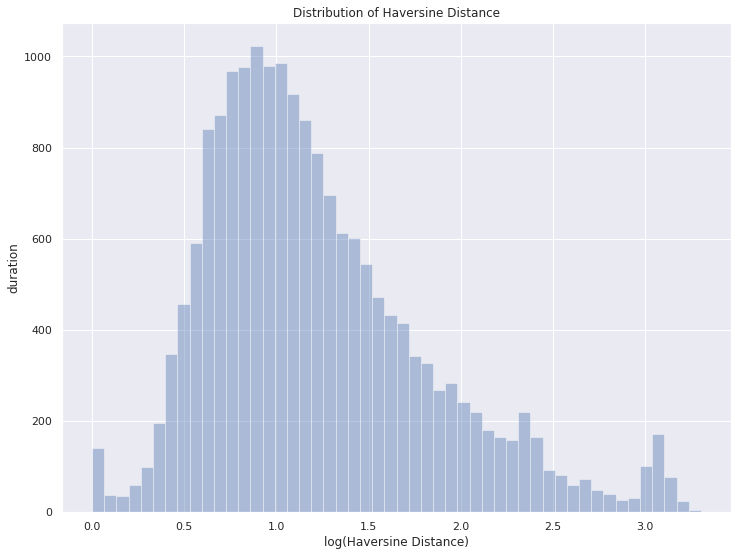

In [36]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.distplot(np.log(train_df['haversine'] + 1),
             ax=ax,
             axlabel='log(Haversine Distance)',
             kde=False).set(ylabel='duration', title ='Distribution of Haversine Distance')

### Question 6c
Justify why you chose this visualization method and how it helps inform you about using manhattan/haversine distance as a feature for predicting trip duration.

In [37]:
q6c_answer = r"""

I chose to take the log of Manhattan/Haversine distance to remove the influence of outliers in the graph and get a better sense of the shape of the distribution. The Manhattan and Haversine ride duration distributions look similar, and the Manhattan distance has a slightly greater mode. The distributions look somewhat normal, and would be useful to use as a feature for predicting ride duration. 

"""

# YOUR CODE HERE
# raise NotImplementedError()

print(q6c_answer)



I chose to take the log of Manhattan/Haversine distance to remove the influence of outliers in the graph and get a better sense of the shape of the distribution. The Manhattan and Haversine ride duration distributions look similar, and the Manhattan distance has a slightly greater mode. The distributions look somewhat normal, and would be useful to use as a feature for predicting ride duration. 




### Question 6d
Fill in the code below to plot a scatter plot of manhattan distance vs duration.

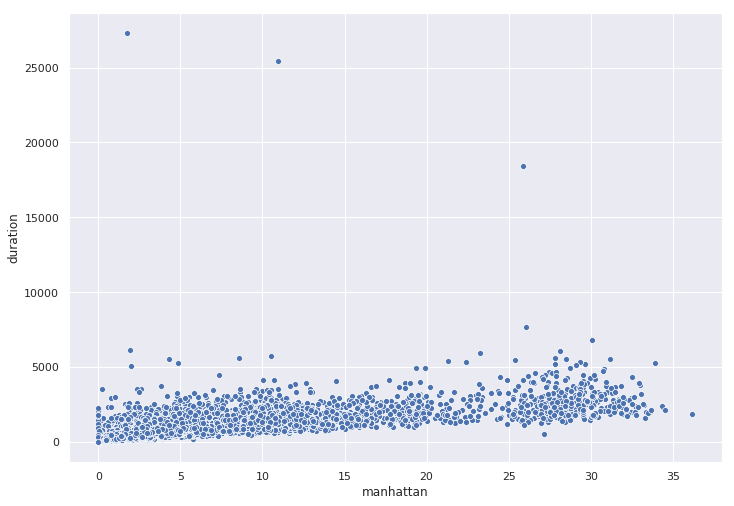

In [38]:
# YOUR CODE HERE
sns.scatterplot(x = "manhattan", y = "duration", data = train_df)

### Question 6e

According to the plot above, there are a few outliers in both duration and manhattan distance. **Which type of outliers is most likely to be a mistake in our data?**

In [39]:
q6e_answer = r"""

The outliers in duration are most likely to be a mistake in the data. 

"""

# YOUR CODE HERE
# raise NotImplementedError()

print(q6e_answer)



The outliers in duration are most likely to be a mistake in the data. 




## 7: Advanced features
You do not need to incorporate these features into your model, although it may help lower your error. You are required to read through this portion and respond to the questions. All of the code is provided, please skim through it and try to understand what each cell is doing.

### Clustering
[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) is the task of grouping objects such that members within each group are more similar to each other than members of other groups. Clustering is a powerful tool used in many fields, including machine learning, pattern recognition, image analysis, information retrieval, bioinformatics, data compression, and computer graphics. Recall cluster sampling, which we learned earlier in the semester. We will use a simple clustering method (clustering by spatial locality) to reveal some more advanced features.

### Speed features

For `train_df`, we have the `duration` and now some distance information.  
This is enough for us to compute average speed and try to better understand our data.   

For `test_df`, we cannot use `duration` as a feature because it is what we are trying to predict. One clever way to include speed information for modeling would be as follows:

1. Cluster the observations in `train_df` by rounding the latitude and longitudes.
2. Compute the average speed per pickup cluster and dropoff cluster.
3. Match each observation in `test_df` to its pickup cluster and dropoff cluster based off the latitude and longitude, thus assigning the average speed for the pickup and dropoff cluster.
4. We have added speed information as features for `test_df`.

Therefore, we have propagated information computed in the `train_df` into the `test_df` via clustering. This is not something we will do in this notebook, although you can try it for yourself!

Other information that could be added based on clustering (both pickup cluster and dropoff cluster):
- Average of `avg_speed_h` per cluster.
- Average of `duration` per cluster.
- Average of `avg_speed_h` per cluster and hour.
- Average of `duration` per cluster and hour.
- In-cluster flow of trips for 60 min period.
- Out-cluster flow of trips for 60 min period.

In [40]:
# Calculate average manhattan speed
train_df['avg_speed_m'] = 1000 * train_df['manhattan'] / train_df['duration']
train_df['avg_speed_m'] = train_df['avg_speed_m'][train_df['avg_speed_m'] < 100]
train_df['avg_speed_m'].fillna(train_df['avg_speed_m'].median(), inplace=True)

In [41]:
train_df['avg_speed_m'].describe()

count    18354.000000
mean         5.210825
std          2.883174
min          0.000000
25%          3.287328
50%          4.617264
75%          6.413992
max         59.225577
Name: avg_speed_m, dtype: float64

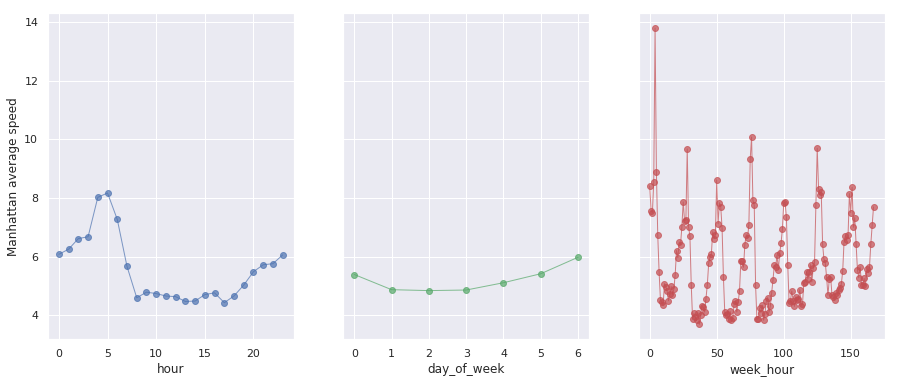

In [42]:
# Visualize average manhattan speed by hour, day of week and week hour
fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)

axes[0].plot(train_df.groupby('hour').mean()['avg_speed_m'], 'bo-', lw=1, alpha=0.7)
axes[1].plot(train_df.groupby('day_of_week').mean()['avg_speed_m'], 'go-', lw=1, alpha=0.7)
axes[2].plot(train_df.groupby('week_hour').mean()['avg_speed_m'], 'ro-', lw=1, alpha=0.7)

axes[0].set_xlabel('hour')
axes[1].set_xlabel('day_of_week')
axes[2].set_xlabel('week_hour')
axes[0].set_ylabel('Manhattan average speed');

### Question 7a
Based off of these visualizations, provide 2-3 insights on the average speed.

In [43]:
q7a_answer = r"""

The Manhattan average speed has a large spike at hour 5, probably because the roads are emptiest in the early morning. It drastically deecreases from hour 5 to 10, probably when the roads are the most clogged due to the morning commute. It also tends to gradually rise from Monday to Saturday, indicating that there are the most people on the road on Monday. 

"""

# YOUR CODE HERE
# raise NotImplementedError()

print(q7a_answer)



The Manhattan average speed has a large spike at hour 5, probably because the roads are emptiest in the early morning. It drastically deecreases from hour 5 to 10, probably when the roads are the most clogged due to the morning commute. It also tends to gradually rise from Monday to Saturday, indicating that there are the most people on the road on Monday. 




We are now going to visualize the average speed per region. Here we define regions as a very basic classical clustering based on rounding of spatial coordinates.

In [44]:
# Round / bin the latitude and longitudes
train_df['start_lat_bin'] = np.round(train_df['pickup_latitude'], 3)
train_df['start_lng_bin'] = np.round(train_df['pickup_longitude'], 3)

# Average speed for regions
gby_cols = ['start_lat_bin', 'start_lng_bin']

coord_stats = (train_df.groupby(gby_cols)
               .agg({'avg_speed_m': 'mean', 'manhattan': 'count'})
               .reset_index())

coord_stats = coord_stats[coord_stats['manhattan'] > 10]

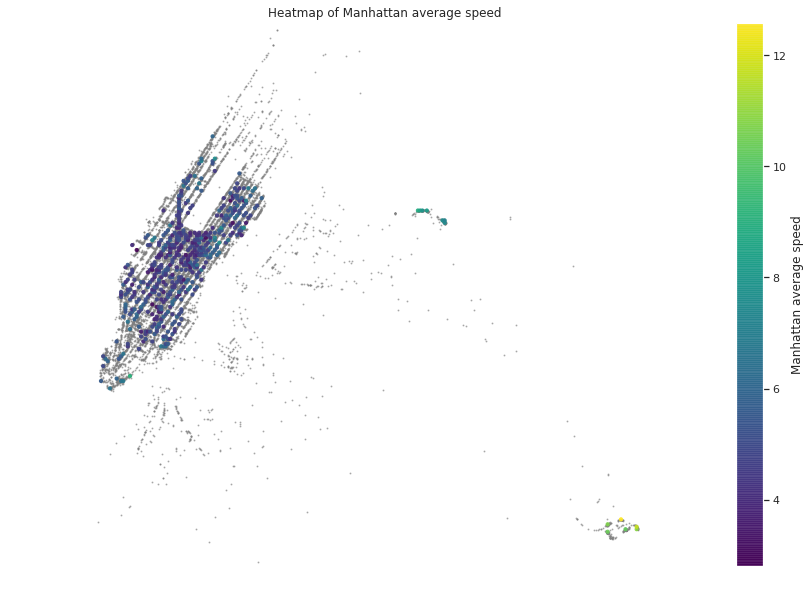

In [45]:
# Visualize the average speed per region
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14, 10))

scatter_trips = ax.scatter(train_df['pickup_longitude'].values,
                           train_df['pickup_latitude'].values,
                           color='grey', s=1, alpha=0.5)

scatter_cmap = ax.scatter(coord_stats['start_lng_bin'].values,
                          coord_stats['start_lat_bin'].values,
                          c=coord_stats['avg_speed_m'].values,
                          cmap='viridis', s=10, alpha=0.9)

cbar = fig.colorbar(scatter_cmap)
cbar.set_label("Manhattan average speed")
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Heatmap of Manhattan average speed')
plt.axis('off');

### Question 7b
In 2-3 sentences, describe how we can use the clustering visualization above to gain insight on the speed. Do you think spatial clustering would be useful in reducing the error of our model?

In [46]:
q7b_answer = r"""

We can use the clustering visualization to see that the Manhattan speed is very low in Manhattan's Midtown/Upper East Side, around 4 mph. The average Manhattan speed is higher near lower Manhattan, about 6 mph. Near LaGuardia Airport, the average Manhattan speed increases to about 12 mph. A spatial clustering would be useful in reducing error. 

"""

# YOUR CODE HERE
# raise NotImplementedError()

print(q7b_answer)



We can use the clustering visualization to see that the Manhattan speed is very low in Manhattan's Midtown/Upper East Side, around 4 mph. The average Manhattan speed is higher near lower Manhattan, about 6 mph. Near LaGuardia Airport, the average Manhattan speed increases to about 12 mph. A spatial clustering would be useful in reducing error. 




## Part 2 Exports
We are not requiring you to export anything from this notebook, but you may find it useful to do so. There is a space below for you to export anything you wish.

In [47]:
Path("data/part2").mkdir(parents=True, exist_ok=True)
data_file = Path("data/part2", "data_part2.hdf") # Path of hdf file
...

Ellipsis

## Part 2 Conclusions 

We now have a good understanding of the taxi data we are working with.
Visualizing large amounts of data can be a difficult task. One helpful tool is [datashader](https://github.com/bokeh/datashader), a data rasterization pipeline for automating the process of creating meaningful representations of large amounts of data. Using the [geopandas](http://geopandas.org/) package also makes working with geospatial data easier. We encourage you to explore these tools if you are interested in learning more about visualization!

Within our taxi data set, we have explored different features and their relationship with ride duration. Now, we are ready to incorporate more data in order to add to our set of features.

**Please proceed to part 3 where we will be engineering more features and building our models using a processing pipeline.**

## Submission

You're almost done!

Before submitting this assignment, ensure that you have:

1. Restarted the Kernel (in the menubar, select Kernel$\rightarrow$Restart & Run All)
2. Validated the notebook by clicking the "Validate" button.

Then,

1. **Submit** the assignment via the Assignments tab in **Datahub** 
1. **Upload and tag** the manually reviewed portions of the assignment on **Gradescope**